In [8]:
from data_provider import *
dm = DataModel(data_location="../excels")

dm.read_from_csvs()

df = dm.get(dm.TA_SYMBOLS[0], "1390-01-01", "1398-01-01")

2020-03-24 06:54:00.802 | DEBUG    | data_provider:read_from_csvs:86 - found csv:  ../excels/master0.csv
2020-03-24 06:54:06.483 | DEBUG    | data_provider:read_from_csvs:86 - found csv:  ../excels/master1.csv


In [9]:
# %%writefile ta_module.py

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
from math import pi
import math
# import trade_model as td
import matplotlib.pyplot as plt
from data_provider import DataModel


accepted_error=0.01



def find_optimum_points(data : list, ismax : bool = True, days = 3):# if input = dataframe it takes 50 times more time
    last = -1000
    x, y = [], []
    if ismax:
        for j in range(len(data)): 
            if (j > days) and (j + days < len(data)):
                if (data[j] >= max(data[j - days: j + days]) and last < j - days):
                    last = j
                    x.append(j)
                    y.append(data[j])
    if not(ismax):
        for j in range(len(data)): 
            if (j > days) and (j + days < len(data)):
                if (data[j]<=min(data[j - days: j + days]) and last < j - days):
                    last = j
                    x.append(j)
                    y.append(data[j])
    df=pd.DataFrame({"x":x ,"y":y})
    return df




#########################################################################
#########################################################################
#########################################################################
#########################################################################


def find_trendlines(df, minimum_touch = 3, mode = "res"): # mode can be either "res" or "sup"
    if mode == "res":
        final_points = []
        points = find_optimum_points(df.log_adj_close.tolist())
        for p1 in range(len(points)):
            for p2 in range(p1+1, len(points)):
                a = (points.y[p2] - points.y[p1]) / (points.x[p2] - points.x[p1])
                b = points.y[p1] - (a * points.x[p1])
                if len(points[p1:p2][points.x*a+b < points.y + math.log10(1 - accepted_error)]) == 0 :

        #                BEFORE : if(x_*a+b>=math.log10((10**y_)-((10**y_)*accepted_error))) and (x_*a+b<=math.log10((10**y_)+((10**y_)*accepted_error))):
                    if len(points[p1:p2][np.logical_and(points.x * a + b >= points.y + math.log10(1 - accepted_error) ,
                                                 points.x * a + b <= points.y + math.log10(1 + accepted_error))])>= minimum_touch:

                        final_points.append([points.x[p1], points.x[p2], a, b])
        return final_points
    
    if mode == "sup":
        final_points = []
        points = find_optimum_points(df.log_adj_close.tolist(), ismax=False)
        for p1 in range(len(points)):
            for p2 in range(p1+1, len(points)):
                a = (points.y[p2] - points.y[p1]) / (points.x[p2] - points.x[p1])
                b = points.y[p1] - (a * points.x[p1])
                if len(points[p1:p2][points.x*a+b > points.y + math.log10(1 + accepted_error)]) == 0 :

    #                BEFORE : if(x_*a+b>=math.log10((10**y_)-((10**y_)*accepted_error))) and (x_*a+b<=math.log10((10**y_)+((10**y_)*accepted_error))):
                    if len(points[p1:p2][np.logical_and(points.x * a + b >= points.y + math.log10(1 - accepted_error) ,
                                                 points.x * a + b <= points.y + math.log10(1 + accepted_error))])>= minimum_touch:
    #                     if :   # delete repetitious lines
                        final_points.append([points.x[p1], points.x[p2], a, b])
        return final_points
   

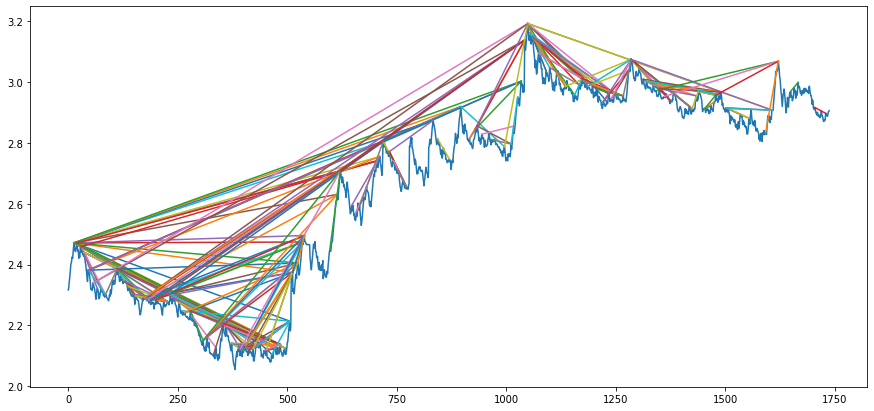

In [11]:
yy = df.log_adj_close.tolist()
# points_min = find_optimum_points(df.log_adj_close.tolist(), ismax=False)
points_max = find_optimum_points(df.log_adj_close.tolist())
# final_points_sup = find_trendlines(df, mode = "sup", minimum_touch=2)
# final_points_res = find_trendlines(df, mode = "res", minimum_touch=2)
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(df)), df.log_adj_close)
for i in final_points_res:
    plt.plot([i[0],i[1]], [i[0]*i[2] +i[3], i[1]*i[2] +i[3]])
# for i in final_points_res:
#     plt.plot([i[0],i[1]], [yy[i[0]], yy[i[1]]])
    
# x = np.array(points_min.x.tolist())
# y = np.array(points_min.y.tolist())
# pullbacks = pullback_points("res")
# xx = np.array(pullbacks.x.tolist())
# yy = np.array(pullbacks.y.tolist())
# plt.scatter(xx, yy)
# plt.scatter(xx, yy + math.log10(1 + accepted_error))
# plt.scatter(xx, yy + math.log10(1 - accepted_error))


In [96]:
#  pull backs on support lines 


def pullback_points(mode = "res"):
    
    points_min = find_optimum_points(df.log_adj_close.tolist(), ismax=False)
    points_max = find_optimum_points(df.log_adj_close.tolist())
    if mode == "sup":
        suplines = pd.DataFrame(find_trendlines(df, mode = "sup", minimum_touch=2), columns=["start", "stop", "coef", "intercept"])
        pullbacks=pd.DataFrame([])
        for ind,r in suplines.iterrows():
            crossed = 0
            touch = points_max[np.logical_and( ((points_max.x * r.coef) + r.intercept)> points_max.y + math.log10(1 - accepted_error),
                                                      ((points_max.x * r.coef) + r.intercept)< points_max.y + math.log10(1 + accepted_error))]

            touch = touch[touch.x > r.stop]
            if len(touch) !=0 :
                first_touch = touch.iloc[0]

                aa = points_min[np.logical_and(points_min.x > r.stop, 
                                               points_min.x < first_touch.x)]
                aa = aa[aa.y  < (aa.x * r.coef)+r.intercept + math.log10(1 - accepted_error)]
                if len(aa)!=0:
                    begin = aa.iloc[0]
                    bb = points_max[np.logical_and(points_max.x > begin.x, 
                                                   points_max.x < first_touch.x)]
                    bb = bb[(bb.x * r.coef)+r.intercept + math.log10(1 + accepted_error) < bb.y ]
                    if len(bb)!=0 :
                        crossed = 1


                if (len(touch) != 0) and not(crossed):
                    pullbacks = pullbacks.append(touch.iloc[0])
        return pullbacks
    if mode == "res":
        reslines = pd.DataFrame(find_trendlines(df, mode = "res", minimum_touch=2), columns=["start", "stop", "coef", "intercept"])
        pullbacks=pd.DataFrame([])
        for ind,r in reslines.iterrows():
            crossed = 0
            touch = points_min[np.logical_and( ((points_min.x * r.coef) + r.intercept)> points_min.y + math.log10(1 - accepted_error),
                                                      ((points_min.x * r.coef) + r.intercept)< points_min.y + math.log10(1 + accepted_error))]

            touch = touch[touch.x > r.stop]
            if len(touch) !=0 : # find out that crosse happened or not 
                first_touch = touch.iloc[0]

                aa = points_max[np.logical_and(points_max.x > r.stop, 
                                               points_max.x < first_touch.x)]
                aa = aa[aa.y  > (aa.x * r.coef)+r.intercept + math.log10(1 + accepted_error)]
                if len(aa)!=0:
                    begin = aa.iloc[0]
                    bb = points_min[np.logical_and(points_min.x > begin.x, 
                                                   points_min.x < first_touch.x)]
                    bb = bb[(bb.x * r.coef)+r.intercept + math.log10(1 - accepted_error) > bb.y ]
                    if len(bb)!=0 :
                        crossed = 1


                if (len(touch) != 0) and not(crossed):
                    pullbacks = pullbacks.append(touch.iloc[0])
        return pullbacks

In [90]:
#  pull backs on resistance lines 

reslines = pd.DataFrame(find_trendlines(df, mode = "res"), columns=["start", "stop", "coef", "intercept"])

pullbacks=pd.DataFrame([])
for ind,r in reslines.iterrows():
    crossed = 0
    touch = points_min[np.logical_and( ((points_min.x * r.coef) + r.intercept)> points_min.y + math.log10(1 - accepted_error),
                                              ((points_min.x * r.coef) + r.intercept)< points_min.y + math.log10(1 + accepted_error))]
    
    touch = touch[touch.x > r.stop]
    if len(touch) !=0 :
        first_touch = touch.iloc[0]

        aa = points_max[np.logical_and(points_max.x > r.stop, 
                                       points_max.x < first_touch.x)]
        aa = aa[aa.y  > (aa.x * r.coef)+r.intercept + math.log10(1 + accepted_error)]
        if len(aa)!=0:
            begin = aa.iloc[0]
            bb = points_min[np.logical_and(points_min.x > begin.x, 
                                           points_min.x < first_touch.x)]
            bb = bb[(bb.x * r.coef)+r.intercept + math.log10(1 - accepted_error) > bb.y ]
            if len(bb)!=0 :
                crossed = 1


        if (len(touch) != 0) and not(crossed):
            pullbacks = pullbacks.append(touch.iloc[0])

/home/nimac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/nimac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [73]:
points_max.iloc[0]["x"]

4.0